### Methodology

**Goal.** Identify which models can reliably recognize **stance** (not just topic).

**Observation (baseline).** Sentence embeddings typically excel at **topic identification** but often fail to distinguish **stance**. For example, texts that **refute** anti-vaccination claims and texts that **promote** anti-vaccination rhetoric may share high topical similarity (both discuss vaccination) while expressing **opposite stances**.

**Illustrative example.** By cosine similarity, a passage is mapped to the topic *vaccination*. However, even when the corpus clearly contains **anti-vaccination** messages, the similarity search also retrieves **counter-argument** passages (refutations), because **topic overlaps** while **stance diverges**.

**Aim.** Test whether **LLM-based classifiers** can infer stance beyond topical overlap.

**Evaluation plan.**
- **Design:** Sample topics where party/club stance is well-established (e.g., **Russian narratives**,  **anti-vaccination** content).
- **Task:** Given a speech segment and target narrative, predict **stance** (e.g., *supports / opposes / neutral*).
- **Assessment:** Compare model predictions against stance priors inferred from club affiliation and manually adjudicated labels on a stratified sample.
- **Reporting:** Accuracy and classwise precision/recall/F1, with confusion matrices; analysis by **club**, **narrative**, and **time slice** (quartiles or periods) to detect systematic biases.


In [1]:

from typing_extensions import TypedDict
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from mistralai import Mistral  
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os
import openai
from openai import OpenAI
import random
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal
from openai import OpenAI
from google import genai
import anthropic
import re
import json
import sys


In [ ]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
from utils.rate_limit import safe_apply_model, RateLimiter

In [3]:
load_dotenv(r"..\keys.env")

True

In [4]:
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY")
mistral_api_key = os.environ["MISTRAL_API_KEY"]
anthropic_api_key = os.getenv("ANTROPHIC_API_KEY")


# Initialize the clients
client = OpenAI(api_key=openai_api_key)
google_model = genai.Client(api_key=google_api_key)
antrophic_client = anthropic.Anthropic(api_key=anthropic_api_key)
mistrals = Mistral(api_key=mistral_api_key)

In [2]:
df = pd.read_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8_narrative_elbow_updated.parquet", engine="fastparquet")

In [5]:
class StancePolarity(BaseModel):
    polarity: Literal["podporuje", "proti", "nevyskytuje sa"]

In [6]:
STANCE_MODELS = {
    # OpenAI Models
    "openai_5": {
        "type": "openai",
        "name": "gpt-5",
        "column": "stance_openai_5",
        "pydantic": True
    },
    "openai_5mini": {
        "type": "openai", 
        "name": "gpt-5-mini",
        "column": "stance_openai_5mini",
        "pydantic": True
    },
    "openai_5nano": {
        "type": "openai",
        "name": "gpt-5-nano", 
        "column": "stance_openai_5nano",
        "pydantic": True
    },
    
    # OpenAI Reasoning Models with different effort levels
    "openai_reasoning_minimal": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "stance_openai_reasoning_minimal",
        "pydantic": True,
        "effort": "minimal"
    },
    "openai_reasoning_low": {
        "type": "openai_reasoning", 
        "name": "gpt-5",
        "column": "stance_openai_reasoning_low",
        "pydantic": True,
        "effort": "low"
    },
    "openai_reasoning_medium": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "stance_openai_reasoning_medium", 
        "pydantic": True,
        "effort": "medium"
    },
    "openai_reasoning_high": {
        "type": "openai_reasoning",
        "name": "gpt-5",
        "column": "stance_openai_reasoning_high",
        "pydantic": True,
        "effort": "high"
    },

    # Anthropic Models
    "anthropic_opus": {
        "type": "anthropic",
        "name": "claude-opus-4-1-20250805",
        "column": "stance_anthropic_opus",
        "pydantic": False
    },
    "anthropic_haiku": {
        "type": "anthropic",
        "name": "claude-3-5-haiku-20241022",
        "column": "stance_anthropic_haiku",
        "pydantic": False
    },
    "anthropic_sonnet_thinking": {
        "type": "anthropic_reasoning",
        "name": "claude-sonnet-4-20250514",
        "column": "stance_anthropic_sonnet_thinking",
        "pydantic": False,
        "effort": "medium"
    },

    # Google Models - Gemini 2.5 series
    "google_gemini_2_5_pro": {
        "type": "google",
        "name": "gemini-2.5-pro",
        "column": "stance_google_gemini_2_5_pro",
        "pydantic": True
    },
    "google_gemini_2_5_flash": {
        "type": "google",
        "name": "gemini-2.5-flash",
        "column": "stance_google_gemini_2_5_flash",
        "pydantic": True
    },
    "google_gemini_2_5_flash_lite": {
        "type": "google",
        "name": "gemini-2.5-flash-lite",
        "column": "stance_google_gemini_2_5_flash_lite",
        "pydantic": True
    },
    
    # Google Thinking Models with different thinking budgets
    "google_thinking_minimal": {
        "type": "google_reasoning",
        "name": "gemini-2.5-flash",
        "column": "stance_google_thinking_minimal",
        "pydantic": True,
        "effort": "minimal"
    },
    "google_thinking_medium": {
        "type": "google_reasoning",
        "name": "gemini-2.5-pro",
        "column": "stance_google_thinking_medium",
        "pydantic": True,
        "effort": "medium"
    },
    "google_thinking_high": {
        "type": "google_reasoning",
        "name": "gemini-2.5-pro", 
        "column": "stance_google_thinking_high",
        "pydantic": True,
        "effort": "high"
    },
    
    # Mistral Models (August 2025 versions)
    "mistral_medium_31": {
        "type": "mistral",
        "name": "mistral-medium-2508",
        "column": "stance_mistral_medium_31",
        "pydantic": True
    },
    "magistral_medium": {
        "type": "mistral", 
        "name": "magistral-medium-2507",
        "column": "stance_magistral_medium",
        "pydantic": True
    },
    "magistral_small": {
        "type": "mistral",
        "name": "magistral-small-2507",
        "column": "stance_magistral_small",
        "pydantic": True
    },
    
    # Gemma Instruction-Tuned Models  
    "gemma_3_27b_it": {
        "type": "gemma",
        "name": "gemma-3-27b-it",
        "column": "stance_gemma_3_27b_it", 
        "pydantic": False
    },
    "gemma_3_12b_it": {
        "type": "gemma",
        "name": "gemma-3-12b-it",
        "column": "stance_gemma_3_12b_it",
        "pydantic": False
    },
    "gemma_3_4b_it": {
        "type": "gemma",
        "name": "gemma-3-4b-it", 
        "column": "stance_gemma_3_4b_it",
        "pydantic": False
    },
    "gemma_3_1b_it": {
        "type": "gemma",
        "name": "gemma-3-1b-it",
        "column": "stance_gemma_3_1b_it",
        "pydantic": False
    } }  

In [8]:
# Create limiters for different models
gemma_limiter = RateLimiter(rpm=30, rpd=14400)  # Gemma: 30 RPM, 14,400 RPD
mistral_limiter = RateLimiter(rps=6)            # Mistral: 6 RPS
openai_limiter = RateLimiter(rpm=3500)          # OpenAI: 3,500 RPM (adjust as needed)
anthropic_limiter = RateLimiter(rpm=240)        # Anthropic: 240 RPM (adjust as needed)

In [9]:
# =========================================================
# Stance Detection Prompt Building Functions
# =========================================================

def build_stance_prompt(text: str, narrative: str) -> str:
    """Build prompt for stance detection towards a specific narrative"""
    return f"""Text je vystupením poslanca Národnej rady Slovenskej republiky. 
    Tvoja úloha je posúdiť postoj tohto vystúpenia voči konkrétnemu naratívu.
    
    Naratív na analýzu: {narrative}
    
    Inštrukcie:
    1. Prečítaj si pozorne vystúpenie poslanca.
    2. Urči, či vystúpenie podporuje daný naratív, je proti nemu, alebo sa naratív nevyskytuje.
    3. Vyber jednu z možností:
    - "podporuje" (vystúpenie podporuje alebo schvaľuje daný naratív)
    - "proti" (vystúpenie kritizuje alebo odmietava daný naratív)  
    - "nevyskytuje sa" (naratív sa v texte nevyskytuje alebo nie je jasne určiteľný)

    Vystúpenie poslanca:
    {text}
    """

def build_stance_prompt_gemma(text: str, narrative: str) -> str:
    """Build prompt for Gemma models (simplified version)"""
    return f"""Text je vystupením poslanca Národnej rady Slovenskej republiky. 
    Tvoja úloha je posúdiť postoj tohto vystúpenia voči konkrétnemu naratívu.
    
    Naratív na analýzu: {narrative}
    
    Inštrukcie:
    1. Prečítaj si pozorne vystúpenie poslanca.
    2. Urči, či vystúpenie podporuje daný naratív, je proti nemu, alebo sa naratív nevyskytuje.
    3. Vyber jednu z možností:
    - "podporuje" (vystúpenie podporuje alebo schvaľuje daný naratív)
    - "proti" (vystúpenie kritizuje alebo odmietava daný naratív)  
    - "nevyskytuje sa" (naratív sa v texte nevyskytuje alebo nie je jasne určiteľný)
    4. Odpovedz výhradne z týchto možností: 
    - "podporuje"
    - "proti"
    - "nevyskytuje sa"

    Vystúpenie poslanca:
    {text}
    """

def extract_polarity_from_json(model_response_text: str) -> str | None:
    """
    Safely parses a model's text response to extract a polarity value from a JSON object.
    """
    if not isinstance(model_response_text, str):
        print(f"Warning: Input was not a string, but {type(model_response_text)}. Cannot extract polarity.")
        return None

    # Attempt to find a JSON object within the response text using a regex.
    json_match = re.search(r'\{.*\}', model_response_text, re.DOTALL)
    if not json_match:
        print(f"Warning: No JSON object found in the model response: '{model_response_text}'")
        return None

    json_string = json_match.group(0)

    try:
        # Parse the extracted JSON string
        data = json.loads(json_string)
        
        # Check if the parsed data is a dictionary and contains the 'polarity' key
        if isinstance(data, dict) and 'polarity' in data:
            polarity = data['polarity']
            
            # Validate that the extracted polarity is one of the expected string values
            if isinstance(polarity, str) and polarity in ["podporuje", "proti", "nevyskytuje sa"]:
                return polarity
            else:
                print(f"Warning: 'polarity' key found, but its value is not a valid polarity string: '{polarity}'")
                return None
        else:
            print(f"Warning: Parsed JSON does not contain a 'polarity' key: '{json_string}'")
            return None

    except json.JSONDecodeError:
        print(f"Error: Failed to decode the extracted JSON string: '{json_string}'")
        return None





In [11]:
NARRATIVES = {
    "anti_vaccine": "Naratív je o škodlivosti očkovaniu, alebo spochybňuje očkovanie, ďaľším znakom je spochybňovanie vakcín, alebo ich účinnosti. Zároveň spochybňuje politiku vlády a spôsob riadenia pandémia COVID-19.",

    "pro_russian": "Naratív je za pro-ruskú zahraničnú politiku, spochybňuje NATO, EÚ, USA a ich politiku voči Rusku. Vojnu na ukrajine dáva za zodpovednosť EÚ, USA a západu, alebo spochybňuje účinosť sankcií.",

    "anti_gender": "Naratív je proti rodovej rovnosti, spochybňuje práva LGBTQ+ osôb, či spochybňuje právo žien na interupcie.",
    }

In [11]:
# =========================================================
# Unified Stance Analysis Functions (adapted from sentiment analysis)
# =========================================================

def analyze_stance(text, narrative, model_type, model_name=None, effort_level=None):
    """
    Unified stance analysis function that handles all model types.
    
    Parameters:
    - text: The text to analyze
    - narrative: The narrative to analyze stance towards
    - model_type: One of "openai", "anthropic", "google", "mistral", "gemma", "openai_reasoning", "anthropic_reasoning", "google_reasoning"
    - model_name: Specific model name (if None, uses default for type)
    - effort_level: For reasoning models - "minimal", "low", "medium", "high"
    
    Returns:
    - Stance polarity as string or StancePolarity object depending on the model
    """
    # Apply rate limiting based on model type
    if model_type in ["openai", "openai_reasoning"]:
        openai_limiter.acquire()
    elif model_type in ["anthropic", "anthropic_reasoning"]:
        anthropic_limiter.acquire()
    elif model_type == "mistral":
        mistral_limiter.acquire()
    elif model_type in ["gemma", "google", "google_reasoning"]:
        gemma_limiter.acquire()
    
    # Use the appropriate prompt format
    if model_type == "gemma":
        prompt = build_stance_prompt_gemma(text, narrative)
    else:
        prompt = build_stance_prompt(text, narrative)
    
    # Process based on model type
    if model_type == "openai":
        model = model_name or "gpt-4o"
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "system", "content": "Ste expert na analýzu postoja slovenských prejavov. Analyzujte postoj voči danému naratívu. Odpovedajte jednou z hodnôt: 'podporuje', 'proti' alebo 'nevyskytuje sa'."},
                {"role": "user", "content": prompt}
            ],
            response_format=StancePolarity,
        )
        return completion.choices[0].message.parsed
    
    elif model_type == "openai_reasoning":
        model = model_name or "gpt-5"
        # Map effort levels to reasoning_effort parameter (GPT-5 supports this directly)
        effort_mapping = {
            "minimal": "minimal",
            "low": "low", 
            "medium": "medium",
            "high": "high"
        }
        reasoning_effort = effort_mapping.get(effort_level, "medium")
        
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "user", "content": f"Ste expert na analýzu postoja slovenských prejavov. Analyzujte postoj voči danému naratívu. Odpovedajte jednou z hodnôt: 'podporuje', 'proti' alebo 'nevyskytuje sa'. {prompt}"}
            ],
            response_format=StancePolarity,
            reasoning_effort=reasoning_effort
        )
        return completion.choices[0].message.parsed
    
    elif model_type == "anthropic":
        model = model_name or "claude-sonnet-4-20250514"
        system_prompt = (
            "Ste expert na analýzu postoja slovenských prejavov. "
            "Prosím, poskytnite klasifikáciu postoja vo formáte JSON nasledovne:\n"
            '{"polarity": "podporuje"}, {"polarity": "proti"} alebo {"polarity": "nevyskytuje sa"} .\n'
            "Odpovedajte len platným JSON, bez ďalšieho textu."
        )
        
        message = antrophic_client.messages.create(
            model=model,
            max_tokens=50,
            temperature=0,
            system=system_prompt,
            messages=[{"role": "user", "content": prompt}]
        )
        
        raw_response_text = message.content[0].text
        polarity_value = extract_polarity_from_json(raw_response_text)
        return polarity_value
    
    elif model_type == "anthropic_reasoning":
        model = model_name or "claude-sonnet-4-20250514"
        # For Anthropic, we simulate reasoning effort through enhanced system prompts
        reasoning_prompts = {
            "minimal": "Rýchlo analyzujte postoj tohto slovenského parlamentného prejavu:",
            "medium": "Dôkladne analyzujte postoj tohto slovenského parlamentného prejavu, zvážte kontext a nuansy:",
            "high": "Veľmi dôkladne analyzujte postoj tohto slovenského parlamentného prejavu s podrobným zvážením kontextu, nuáns a implikácií:"
        }
        reasoning_prompt = reasoning_prompts.get(effort_level, reasoning_prompts["medium"])
        
        system_prompt = (
            f"{reasoning_prompt} "
            "Ste expert na analýzu postoja slovenských prejavov. "
            "Prosím, poskytnite klasifikáciu postoja vo formáte JSON nasledovne:\n"
            '{"polarity": "podporuje"}, {"polarity": "proti"} alebo {"polarity": "nevyskytuje sa"} .\n'
            "Odpovedajte len platným JSON, bez ďalšieho textu."
        )
        
        message = antrophic_client.messages.create(
            model=model,
            max_tokens=100,
            temperature=0,
            system=system_prompt,
            messages=[{"role": "user", "content": prompt}]
        )
        
        raw_response_text = message.content[0].text
        polarity_value = extract_polarity_from_json(raw_response_text)
        return polarity_value

    elif model_type == "google":
        model = model_name or "gemini-2.5-flash"
        # Fix the contents format for Google Gemini API
        full_prompt = f"Analyzuj postoj a odpovedz len hodnotu podporuje, proti alebo nevyskytuje sa v nasledujúcom formáte JSON: {{\"polarity\": \"podporuje\"}}, {{\"polarity\": \"proti\"}} alebo {{\"polarity\": \"nevyskytuje sa\"}}.\n\n{prompt}"
        
        response = google_model.models.generate_content(
            model=model,
            contents=full_prompt,
            config={
                'response_mime_type': 'application/json',
                'response_schema': StancePolarity,
            },
        )
        return response.parsed
    
    elif model_type == "google_reasoning":
        from google.genai import types
        
        model = model_name or "gemini-2.5-pro"
        
        # Map effort levels to thinking budgets
        thinking_budgets = {
            "minimal": 512,     # Low thinking budget for simple analysis
            "medium": 2048,     # Medium thinking budget for balanced analysis  
            "high": 8192        # High thinking budget for complex analysis
        }
        thinking_budget = thinking_budgets.get(effort_level, 2048)
        
        # Fix the contents format for Google Gemini API with thinking
        full_prompt = f"Analyzuj postoj tohto slovenského parlamentného prejavu a odpovedz len hodnotu podporuje, proti alebo nevyskytuje sa v nasledujúcom formáte JSON: {{\"polarity\": \"podporuje\"}}, {{\"polarity\": \"proti\"}} alebo {{\"polarity\": \"nevyskytuje sa\"}}.\n\nText: {prompt}"
        
        response = google_model.models.generate_content(
            model=model,
            contents=full_prompt,
            config=types.GenerateContentConfig(
                response_mime_type='application/json',
                response_schema=StancePolarity,
                thinking_config=types.ThinkingConfig(
                    thinking_budget=thinking_budget,
                    include_thoughts=False  # We don't need thought summaries for this task
                )
            ),
        )
        return response.parsed
    
    elif model_type == "mistral":
        model = model_name or "mistral-medium-2508"
        response = mistrals.chat.parse(
            model=model,
            messages=[
                {"role": "system", "content": "Ste expert na analýzu postoja slovenských prejavov. Analyzujte postoj voči danému naratívu. Odpovedajte jednou z hodnôt: 'podporuje', 'proti' alebo 'nevyskytuje sa'."},
                {"role": "user", "content": prompt}
            ],
            response_format=StancePolarity
        )
        return response.choices[0].message.parsed
    
    elif model_type == "gemma":
        model = model_name or "gemma-3-27b-it"
        response = google_model.models.generate_content(
            model=model,
            contents=prompt
        )
        return response.text.strip().lower()
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")




In [12]:
# =========================================================
# Safe Retry Helper for Stance Detection
# =========================================================

def safe_apply_stance_model(model_func, text, narrative, is_pydantic=True, retries=4, base=2, jitter=1):
    """
    Unified retry helper for stance detection
    """
    for attempt in range(retries):
        try:
            if pd.isna(text):
                return None
                
            result = model_func(text, narrative)
            # Extract polarity from Pydantic model or use string directly
            return result.polarity if is_pydantic else result
            
        except Exception as e:
            wait = base * 2**attempt + random.uniform(0, jitter)
            print(f"Error: {e}. Retrying in {wait:.1f}s (attempt {attempt+1}/{retries})")
            time.sleep(wait)
            
    print("Max retries reached. Returning None.")
    return None

# =========================================================
# Stance Detection Testing Functions
# =========================================================

def test_stance_on_sample(df, narrative_key, narrative_text, model_key, sample_size=10):
    """
    Test stance detection on a sample of data for a specific narrative
    
    Parameters:
    - df: DataFrame containing the speeches
    - narrative_key: Key for the narrative (e.g., "anti_vaccine")
    - narrative_text: The actual narrative description
    - model_key: Key from STANCE_MODELS dictionary
    - sample_size: Number of samples to test
    
    Returns:
    - DataFrame with results
    """
    if sample_size and sample_size < len(df):
        sample_df = df.sample(sample_size, random_state=42).copy()
    else:
        sample_df = df.copy()
    
    model_config = STANCE_MODELS[model_key]
    is_pydantic = model_config["pydantic"]
    
    print(f"Testing {model_key} on {len(sample_df)} samples for narrative: {narrative_key}")
    
    # Create a function that calls the model with the right parameters
    def worker(text):
        return safe_apply_stance_model(
            lambda t, n: analyze_stance(t, n, model_config["type"], model_config["name"]),
            text,
            narrative_text,
            is_pydantic=is_pydantic
        )
    
    # Process with progress bar
    results = []
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc=f"Processing {model_key}"):
        result = worker(row['prepis'])
        results.append(result)
    
    # Add results to dataframe
    column_name = f"stance_{narrative_key}_{model_key}"
    sample_df[column_name] = results
    
    # Print statistics
    non_null = pd.Series(results).notna().sum()
    print(f"Completed {non_null} out of {len(sample_df)} rows ({non_null/len(sample_df)*100:.1f}%)")
    
    if non_null > 0:
        stance_counts = pd.Series(results).value_counts(normalize=True) * 100
        print(f"Stance distribution for {narrative_key}:")
        for stance, percentage in stance_counts.items():
            print(f"  - {stance}: {percentage:.1f}%")
    
    return sample_df

def run_stance_analysis_for_narrative(df, narrative_key, narrative_text, models_to_test=None, sample_size=20):
    """
    Run stance analysis for a specific narrative across multiple models
    
    Parameters:
    - df: DataFrame containing the speeches
    - narrative_key: Key for the narrative (e.g., "anti_vaccine")
    - narrative_text: The actual narrative description
    - models_to_test: List of model keys to test (if None, uses all)
    - sample_size: Number of samples to test per model
    """
    if models_to_test is None:
        models_to_test = list(STANCE_MODELS.keys())
    
    results = {}
    
    print(f"\n=== TESTING STANCE DETECTION FOR: {narrative_key.upper()} ===")
    print(f"Narrative: {narrative_text[:100]}...")
    
    for model_key in models_to_test:
        try:
            result_df = test_stance_on_sample(df, narrative_key, narrative_text, model_key, sample_size)
            results[model_key] = result_df
            print(f"✅ {model_key} completed successfully\n")
        except Exception as e:
            print(f"❌ {model_key} failed: {str(e)}\n")
    
    return results

def compare_stance_results(results, narrative_key):
    """
    Compare stance detection results across different models
    """
    if not results:
        print("No results to compare")
        return
    
    print(f"\n=== STANCE COMPARISON FOR {narrative_key.upper()} ===")
    
    # Get all stance columns
    stance_columns = []
    for model_key in results.keys():
        col_name = f"stance_{narrative_key}_{model_key}"
        if col_name in results[model_key].columns:
            stance_columns.append((model_key, col_name))
    
    if len(stance_columns) < 2:
        print("Not enough models with results to compare")
        return
    
    # Create comparison dataframe
    comparison_data = {}
    for model_key, col_name in stance_columns:
        comparison_data[model_key] = results[model_key][col_name]
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Print distribution for each model
    print("Stance distributions by model:")
    for model_key, _ in stance_columns:
        if model_key in comparison_df.columns:
            dist = comparison_df[model_key].value_counts(normalize=True) * 100
            print(f"\n{model_key}:")
            for stance, pct in dist.items():
                print(f"  {stance}: {pct:.1f}%")
    
    return comparison_df

In [13]:
# =========================================================
# CLEAN STANCE DETECTION APPLICATION
# Stores results directly as new columns in DataFrame
# =========================================================

def add_stance_columns_for_narrative(df, narrative, models_to_test=None, min_uniques=3):
    """
    Add stance detection columns for a specific narrative to the DataFrame
    
    Parameters:
    - df: DataFrame with uniques columns (modified in place)
    - narrative: 'vaccine', 'russian', or 'gender'
    - models_to_test: List of model keys (default: balanced selection)
    - min_uniques: Minimum consensus threshold (default: 3)
    
    Returns:
    - Modified DataFrame with new stance columns
    """
    
    # Map narrative names
    narrative_mapping = {
        'vaccine': 'anti_vaccine',
        'russian': 'pro_russian', 
        'gender': 'anti_gender'
    }
    
    if narrative not in narrative_mapping:
        print(f"❌ Invalid narrative. Use: {list(narrative_mapping.keys())}")
        return df
    
    stance_narrative_key = narrative_mapping[narrative]
    stance_narrative_text = NARRATIVES[stance_narrative_key]
    
    # Check uniques column exists
    uniques_col = f"{narrative}_uniques"
    if uniques_col not in df.columns:
        print(f"❌ Column {uniques_col} not found")
        return df
    
    # Filter for high consensus
    high_consensus_mask = df[uniques_col] > min_uniques
    high_consensus_count = high_consensus_mask.sum()
    
    if high_consensus_count == 0:
        print(f"❌ No high consensus data for {narrative}")
        return df
    
    print(f"📊 {narrative.upper()}: {high_consensus_count:,} speeches (>{min_uniques} models agree)")
    
    # Default models - USE ALL MODELS when None is passed
    if models_to_test is None:
        models_to_test = list(STANCE_MODELS.keys())  # All 23 models
    
    # Process each model
    for model_key in models_to_test:
        if model_key not in STANCE_MODELS:
            continue
            
        column_name = f"{model_key}_{narrative}"
        
        # Skip if exists
        if column_name in df.columns:
            continue
        
        # Initialize column
        df[column_name] = None
        model_config = STANCE_MODELS[model_key]
        is_pydantic = model_config["pydantic"]
        
        print(f"  🤖 {model_key}...", end="")
        
        # Process high consensus rows
        processed = 0
        for idx in df[high_consensus_mask].index:
            text = df.loc[idx, 'prepis']
            if pd.isna(text):
                continue
                
            try:
                def model_func(t, n):
                    return analyze_stance(t, n, model_config["type"], 
                                        model_config["name"], 
                                        model_config.get("effort", None))
                
                result = safe_apply_stance_model(
                    model_func, text, stance_narrative_text, is_pydantic=is_pydantic
                )
                
                df.loc[idx, column_name] = result
                processed += 1
                    
            except Exception:
                continue
        
        print(f" ✅ {processed:,} completed")
    
    return df

def add_all_stance_columns(df, narratives=None, models=None, min_uniques=3):
    """
    Add stance detection columns for all narratives
    
    Parameters:
    - df: DataFrame with uniques columns (modified in place)
    - narratives: List of narratives (default: all)
    - models: List of models (default: balanced selection)
    - min_uniques: Consensus threshold (default: 3)
    
    Returns:
    - Modified DataFrame with all stance columns
    """
    
    if narratives is None:
        narratives = ['vaccine', 'russian', 'gender']
    
    if models is None:
        models = list(STANCE_MODELS.keys())  # All 23 models
    
    print(f"🚀 ADDING STANCE COLUMNS")
    print(f"Narratives: {narratives}")
    print(f"Models: {len(models)} models")
    print(f"Consensus: >{min_uniques} models must agree")
    
    initial_columns = len(df.columns)
    
    # Process each narrative
    for narrative in narratives:
        print(f"\n📝 {narrative.upper()}")
        try:
            df = add_stance_columns_for_narrative(df, narrative, models, min_uniques)
        except Exception as e:
            print(f"❌ Error: {str(e)}")
    
    # Summary
    new_columns = len(df.columns) - initial_columns
    print(f"\n✅ Added {new_columns} new stance columns")
    
    return df

def stance_summary(df, narratives=['vaccine', 'russian', 'gender']):
    """
    Show summary of stance detection results
    
    Parameters:
    - df: DataFrame with stance columns
    - narratives: Narratives to summarize
    """
    
    print("📊 STANCE RESULTS SUMMARY")
    print("="*50)
    
    for narrative in narratives:
        cols = [col for col in df.columns if col.endswith(f"_{narrative}")]
        
        if not cols:
            continue
        
        print(f"\n{narrative.upper()}:")
        for col in sorted(cols):
            total = df[col].notna().sum()
            if total == 0:
                continue
                
            print(f"  {col}: {total:,} values")
            for stance, count in df[col].value_counts().items():
                pct = (count / total) * 100
                print(f"    {stance}: {count:,} ({pct:.1f}%)")

# =========================================================
# MAIN APPLICATION FUNCTION
# =========================================================

def process_stance_detection(df, min_consensus=3, narratives=None, models=None):
    """
    Main function to process stance detection and add columns to DataFrame
    
    Parameters:
    - df: DataFrame with uniques columns
    - min_consensus: Models that must agree (default: 3)
    - narratives: Narratives to process (default: all)
    - models: Models to use (default: balanced selection)
    
    Returns:
    - DataFrame with stance columns added
    """
    
    print("🎯 STANCE DETECTION PROCESSING")
    print("="*40)
    
    # Add columns
    df_result = add_all_stance_columns(df, narratives, models, min_consensus)
    
    # Show summary
    stance_summary(df_result, narratives or ['vaccine', 'russian', 'gender'])
    
    print("\n✅ COMPLETE!")
    return df_result



In [17]:
def run_final_analysis_with_checkpoints(df, models, min_consensus=4, narratives=['vaccine', 'russian', 'gender'], checkpoint_dir='model_checkpoints'):
    """
    Run stance detection for all models, saving a checkpoint after each model's full narrative processing.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    df_result = df.copy()
    total_models = len(models)
    print(f"🚀 Starting final analysis with {total_models} models and checkpoints.")
    print(f"Checkpoints will be saved in: {checkpoint_dir}/")

    for idx, model_key in enumerate(models, 1):
        print(f"\n🔄 Processing model {idx}/{total_models}: {model_key}")
        for narrative in narratives:
            print(f"   - Narrative: {narrative}")
            df_result = add_stance_columns_for_narrative(df_result, narrative, models_to_test=[model_key], min_uniques=min_consensus)
        
        # Save checkpoint after this model
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{idx:02d}_{model_key}.parquet")
        df_result.to_parquet(checkpoint_path, index=False)
        print(f"   ✅ Checkpoint saved: {checkpoint_path}")

    print("\n🎉 All models processed. Final DataFrame is ready.")
    return df_result

def run_rerun_for_missing_only(df, problematic_models, min_consensus=4, narratives=['vaccine', 'russian', 'gender'], checkpoint_dir='rerun_checkpoints'):
    """
    Efficient rerun function that ONLY processes missing values (None) for problematic models.
    Skips rows that already have values.
    
    Parameters:
    - df: DataFrame with existing stance columns
    - problematic_models: List of model keys that had quota/rate limit issues
    - min_consensus: Minimum consensus for narrative detection
    - narratives: Narratives to process
    - checkpoint_dir: Directory to save checkpoints
    
    Returns:
    - Updated DataFrame
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    df_result = df.copy()
    total_models = len(problematic_models)
    
    print(f"🎯 SMART RERUN: Only processing missing values for {total_models} problematic models")
    print(f"Problematic models: {problematic_models}")
    print(f"Checkpoints will be saved in: {checkpoint_dir}/")
    
    # Map narrative names
    narrative_mapping = {
        'vaccine': 'anti_vaccine',
        'russian': 'pro_russian', 
        'gender': 'anti_gender'
    }

    for idx, model_key in enumerate(problematic_models, 1):
        if model_key not in STANCE_MODELS:
            print(f"❌ Model {model_key} not found in STANCE_MODELS")
            continue
            
        print(f"\n🔄 Processing model {idx}/{total_models}: {model_key}")
        model_config = STANCE_MODELS[model_key]
        is_pydantic = model_config["pydantic"]
        
        total_processed_this_model = 0
        
        for narrative in narratives:
            stance_narrative_key = narrative_mapping[narrative]
            stance_narrative_text = NARRATIVES[stance_narrative_key]
            
            # Check uniques column exists
            uniques_col = f"{narrative}_uniques"
            if uniques_col not in df_result.columns:
                print(f"   ❌ {uniques_col} not found")
                continue
            
            # Filter for high consensus (narrative detected)
            high_consensus_mask = df_result[uniques_col] > min_consensus
            high_consensus_count = high_consensus_mask.sum()
            
            if high_consensus_count == 0:
                print(f"   📊 {narrative.upper()}: 0 speeches with consensus")
                continue
            
            # Check if column exists
            column_name = f"{model_key}_{narrative}"
            if column_name not in df_result.columns:
                # Create column if it doesn't exist
                df_result[column_name] = None
                print(f"   📊 {narrative.upper()}: Created new column")
            
            # Find missing values ONLY in rows where narrative was detected
            missing_mask = (high_consensus_mask) & (df_result[column_name].isna())
            missing_count = missing_mask.sum()
            
            if missing_count == 0:
                print(f"   📊 {narrative.upper()}: No missing values (all {high_consensus_count} already processed)")
                continue
            
            print(f"   📊 {narrative.upper()}: {missing_count} missing values to process (out of {high_consensus_count} total)")
            
            # Process ONLY missing values
            processed = 0
            for idx_row in df_result[missing_mask].index:
                text = df_result.loc[idx_row, 'prepis']
                if pd.isna(text):
                    continue
                    
                try:
                    def model_func(t, n):
                        return analyze_stance(t, n, model_config["type"], 
                                            model_config["name"], 
                                            model_config.get("effort", None))
                    
                    result = safe_apply_stance_model(
                        model_func, text, stance_narrative_text, is_pydantic=is_pydantic
                    )
                    
                    df_result.loc[idx_row, column_name] = result
                    processed += 1
                    total_processed_this_model += 1
                        
                except Exception as e:
                    print(f"     ❌ Error processing row {idx_row}: {str(e)}")
                    continue
            
            print(f"   ✅ {narrative.upper()}: {processed} values filled")
        
        # Save checkpoint after this model
        checkpoint_path = os.path.join(checkpoint_dir, f"rerun_{idx:02d}_{model_key}.parquet")
        df_result.to_parquet(checkpoint_path, index=False)
        print(f"   ✅ Model checkpoint: {total_processed_this_model} total values processed")
        print(f"   💾 Saved: {checkpoint_path}")

    print(f"\n🎉 Smart rerun completed for {total_models} problematic models!")
    return df_result

In [19]:
# 🎯 SMART RERUN SETUP - Only for problematic models with missing values
def run_smart_rerun_for_problematic_models(df):
    """
    Simple function to run rerun only for models that had quota/rate limit issues
    """
    
    # Define your problematic models (the ones that hit quotas/rate limits)
    problematic_models = [
        'gemma_3_27b_it',      # Hit Google quota limits
        'gemma_3_12b_it',      # Hit Google quota limits  
        'gemma_3_4b_it',       # Hit Google quota limits
        'gemma_3_1b_it',       # Hit Google quota limits
        'magistral_medium',    # Hit Mistral rate limits
        'magistral_small'      # Hit Mistral rate limits
    ]
    
    print("🎯 SMART RERUN FOR PROBLEMATIC MODELS")
    print("=" * 50)
    print(f"Problematic models to rerun: {len(problematic_models)}")
    for model in problematic_models:
        print(f"  🤖 {model}")
    
    print(f"\n🧠 SMART LOGIC:")
    print(f"  ✅ Only process missing values (None)")
    print(f"  ✅ Only process rows where narrative was detected (>4 consensus)")
    print(f"  ✅ Skip rows that already have values")
    print(f"  ✅ Save checkpoint after each model")
    
    # Run the smart rerun
    df_updated = run_rerun_for_missing_only(
        df, 
        problematic_models=problematic_models,
        min_consensus=4,
        narratives=['vaccine', 'russian', 'gender']
    )
    
    return df_updated

# 🚀 READY TO RUN!
print("✅ Smart rerun functions ready!")
print("\nTo run the smart rerun:")
print("df_stance = run_smart_rerun_for_problematic_models(df_stance)")

✅ Smart rerun functions ready!

To run the smart rerun:
df_stance = run_smart_rerun_for_problematic_models(df_stance)


In [20]:
df_stance = run_smart_rerun_for_problematic_models(df_stance)

🎯 SMART RERUN FOR PROBLEMATIC MODELS
Problematic models to rerun: 6
  🤖 gemma_3_27b_it
  🤖 gemma_3_12b_it
  🤖 gemma_3_4b_it
  🤖 gemma_3_1b_it
  🤖 magistral_medium
  🤖 magistral_small

🧠 SMART LOGIC:
  ✅ Only process missing values (None)
  ✅ Only process rows where narrative was detected (>4 consensus)
  ✅ Skip rows that already have values
  ✅ Save checkpoint after each model
🎯 SMART RERUN: Only processing missing values for 6 problematic models
Problematic models: ['gemma_3_27b_it', 'gemma_3_12b_it', 'gemma_3_4b_it', 'gemma_3_1b_it', 'magistral_medium', 'magistral_small']
Checkpoints will be saved in: rerun_checkpoints/

🔄 Processing model 1/6: gemma_3_27b_it
   📊 VACCINE: 2 missing values to process (out of 38 total)
   ✅ VACCINE: 2 values filled
   📊 RUSSIAN: 2 missing values to process (out of 34 total)
   ✅ VACCINE: 2 values filled
   📊 RUSSIAN: 2 missing values to process (out of 34 total)
   ✅ RUSSIAN: 2 values filled
   📊 GENDER: 1 missing values to process (out of 28 total)
 

In [15]:
all_models = list(STANCE_MODELS.keys())

I want use only the clubs, when I am sure the stance to the narratives.

In [20]:
df = df[~df["klub"].isin(['(OĽANO)', '(ZA ĽUDÍ)', '(SME RODINA)', '(-)', None, '(MOST-HÍD)' ,  '(SMER - SD)'])]

In [21]:
df_stance = df[
    (df['vaccine_uniques'] > 4) |
    (df['russian_uniques'] > 4) |
    (df['gender_uniques'] > 4)
]


In [22]:
df_stance = df_stance[(df_stance['num_tokens_mistral'] <= 3000) & (df_stance['num_tokens_mistral'] > 250)]

In [23]:
# Calculate the proportion of each club in the original dataset
club_proportions = df_stance['klub'].value_counts(normalize=True)
print("Original club distribution:")
print(club_proportions)

# Calculate sample size for each club based on proportions
sample_size = 100
club_sample_sizes = (club_proportions * sample_size).round().astype(int)

# Ensure we get exactly 100 samples
while club_sample_sizes.sum() != sample_size:
    if club_sample_sizes.sum() < sample_size:
        # Add 1 to the largest club
        largest_club = club_sample_sizes.idxmax()
        club_sample_sizes[largest_club] += 1
    else:
        # Remove 1 from the largest club
        largest_club = club_sample_sizes.idxmax()
        club_sample_sizes[largest_club] -= 1

print(f"\nSample sizes per club (total: {club_sample_sizes.sum()}):")
print(club_sample_sizes)

# Perform stratified sampling
df_stance = df_stance.groupby('klub', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), club_sample_sizes[x.name]), random_state=42)
)

print(f"\nActual sample distribution:")
print(df_stance['klub'].value_counts().sort_index())
print(f"Total samples: {len(df_stance)}")

Original club distribution:
klub
(Republika)            0.418182
(SaS)                  0.312121
(ĽS Naše Slovensko)    0.269697
Name: proportion, dtype: float64

Sample sizes per club (total: 100):
klub
(Republika)            42
(SaS)                  31
(ĽS Naše Slovensko)    27
Name: proportion, dtype: int32

Actual sample distribution:
klub
(Republika)            42
(SaS)                  31
(ĽS Naše Slovensko)    27
Name: count, dtype: int64
Total samples: 100


C:\Users\alexe\AppData\Local\Temp\ipykernel_38192\3643329104.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stance = df_stance.groupby('klub', group_keys=False).apply(


In [ ]:
df_stance = run_final_analysis_with_checkpoints(df_stance, all_models, min_consensus=4)

In [15]:
df_stance = pd.read_parquet(r"..\data\df_stance.parquet", engine='fastparquet')

In [32]:
# =========================================================
# 🎨 HIGH-RESOLUTION HORIZONTAL CHART - STANCE ACCURACY ALL MODELS
# =========================================================

def create_stance_accuracy_chart(df, narrative='russian'):
    """
    Create high-resolution horizontal chart showing model accuracy for stance detection
    
    Based on political context:
    - SaS in "podporuje" = MISTAKE (SaS should be 'proti' Russian narratives)
    - Other clubs in "podporuje" = CORRECT (for pro-Russian clubs like ĽSNS, )
    - "Proti" = CORRECT for anti-Russian clubs (SaS,)
    - "Nevyskytuje sa" = NO_NARRATIVE 
    - "Nespoľahlivé" = UNRELIABLE (no prediction)
    """
    
    from datetime import datetime
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd  # ensure pd is available inside the function
    
    # Set up high-resolution matplotlib parameters
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 600
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    
    # Define expected stances based on political reality
    expected_stances = {
        'russian': {
            '(SaS)': 'proti',                    # SaS is pro-Western, should be against Russian narratives
            '(ĽS Naše Slovensko)': 'podporuje',  # ĽSNS is far-right, pro-Russian
            '(Republika)': 'podporuje',          # Republika far-right, pro-Russian
        },
        "vaccine": {
            '(SaS)': 'proti',
            '(ĽS Naše Slovensko)': 'podporuje',
            '(Republika)': 'podporuje',
        },
        "gender": {
            '(SaS)': 'proti',
            '(ĽS Naše Slovensko)': 'podporuje',
            '(Republika)': 'podporuje',
        }
    }

    if narrative not in expected_stances:
        print(f"❌ No expected stances defined for {narrative}")
        return
    
    # Get stance columns for this narrative
    stance_cols = [col for col in df.columns if col.endswith(f'_{narrative}') and df[col].notna().sum() > 0]
    
    if not stance_cols:
        print(f"❌ No stance data found for {narrative}")
        return
    
    # Calculate accuracy for each model
    model_results = []
    
    for col in stance_cols:
        model_name = col.replace(f'_{narrative}', '')
        
        # Get all predictions for this model
        model_data = df[df[col].notna()].copy()
        if len(model_data) == 0:
            continue
        
        # Calculate accuracy metrics
        total_predictions = len(model_data)
        mistakes = 0          # SaS in "podporuje" or general mismatch
        correct = 0           # Proper club-stance alignment
        no_narrative = 0      # "nevyskytuje sa"
        unreliable = total_predictions - df[col].notna().sum()  # (kept logic)
        
        for _, row in model_data.iterrows():
            club = row['klub']
            predicted_stance = row[col]
            expected_stance = expected_stances[narrative].get(club, None)

            if expected_stance and predicted_stance != expected_stance and predicted_stance != 'nevyskytuje sa':
                mistakes += 1
            elif expected_stance and predicted_stance == expected_stance:
                correct += 1
            elif predicted_stance == 'nevyskytuje sa':
                no_narrative += 1
            else:
                # No expected stance defined for this club -> treat as no_narrative bucket
                no_narrative += 1
        
        # Percentages
        mistake_pct = (mistakes / total_predictions) * 100 if total_predictions > 0 else 0
        correct_pct = (correct / total_predictions) * 100 if total_predictions > 0 else 0
        no_narrative_pct = (no_narrative / total_predictions) * 100 if total_predictions > 0 else 0
        unreliable_pct = (unreliable / (total_predictions + unreliable)) * 100 if (total_predictions + unreliable) > 0 else 0
        
        # Determine model type
        model_lower = model_name.lower()
        if 'openai' in model_lower or 'gpt' in model_lower:
            model_type = 'OpenAI'
        elif 'anthropic' in model_lower or 'claude' in model_lower:
            model_type = 'Anthropic'
        elif 'google' in model_lower or 'gemini' in model_lower:
            model_type = 'Google'
        elif 'mistral' in model_lower or 'magistral' in model_lower:
            model_type = 'Mistral'
        elif 'gemma' in model_lower:
            model_type = 'Gemma'
        else:
            model_type = 'Other'
        
        model_results.append({
            'model': model_name,
            'model_type': model_type,
            'mistake_pct': mistake_pct,
            'correct_pct': correct_pct,
            'no_narrative_pct': no_narrative_pct,
            'unreliable_pct': unreliable_pct,
            'total_predictions': total_predictions,
            'is_gemma': 'gemma' in model_lower
        })
    
    # Convert to DataFrame and sort by mistakes (ascending - fewer mistakes = better)
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('mistake_pct', ascending=True)
    
    # Calculate optimal figure size based on number of models
    num_models = len(results_df)
    fig_height = max(16, num_models * 0.6)  # At least 16 inches, more if many models
    
    # Create large horizontal chart for ALL models
    fig, ax = plt.subplots(figsize=(20, fig_height))
    
    # Enhanced color scheme for stance analysis
    stance_colors = {
        'mistake': '#E74C3C',        # Red - Critical mistakes
        'correct': '#27AE60',        # Green - Correct predictions
        'no_narrative': '#F39C12',   # Orange - No narrative / 'nevyskytuje sa'
        'unreliable': '#95A5A6'      # Gray - No prediction / unreliable
    }
    
    # Prepare data for ALL models
    y_positions_all = range(len(results_df))
    models_all = results_df['model'].tolist()
    mistake_all = results_df['mistake_pct'].tolist()
    correct_all = results_df['correct_pct'].tolist()
    no_narrative_all = results_df['no_narrative_pct'].tolist()
    unreliable_all = results_df['unreliable_pct'].tolist()
    
    # Create horizontal stacked bars with enhanced colors
    bars1_all = ax.barh(y_positions_all, mistake_all, label='Wrong', 
                        color=stance_colors['mistake'], alpha=0.9, height=0.8)
    bars2_all = ax.barh(y_positions_all, correct_all, left=mistake_all, 
                        label='Correct', color=stance_colors['correct'], alpha=0.9, height=0.8)

    no_narrative_left_all = [mis + cor for mis, cor in zip(mistake_all, correct_all)]
    bars3_all = ax.barh(y_positions_all, no_narrative_all, left=no_narrative_left_all,
                        label='No narrative', color=stance_colors['no_narrative'], alpha=0.9, height=0.8)

    unreliable_left_all = [mis + cor + nn for mis, cor, nn in zip(mistake_all, correct_all, no_narrative_all)]
    bars4_all = ax.barh(y_positions_all, unreliable_all, left=unreliable_left_all,
                        label='Unreliable', color=stance_colors['unreliable'], alpha=0.9, height=0.8)

    # Enhanced chart customization
    ax.set_title(f'📊 Model Accuracy: {narrative.upper()} Narrative Stance Detection\n(Ranked by Fewest Mistakes - Lower Red = Better)', 
                 fontsize=24, fontweight='bold', pad=30)
    ax.set_xlabel('Percentage (%)', fontsize=20, fontweight='bold')
    ax.set_ylabel('Models (Ranked by Accuracy)', fontsize=20, fontweight='bold')
    ax.set_xlim(0, 120)
    ax.set_yticks(y_positions_all)
    
    # Enhanced model names with rank numbers at the start
    enhanced_model_names = []
    for i, (model, is_gemma) in enumerate(zip(models_all, results_df['is_gemma'])):
        rank = i + 1
        enhanced_model_names.append(f"#{rank} {'★ ' if is_gemma else ''}{model}")
    
    ax.set_yticklabels(enhanced_model_names, fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
    ax.legend(loc='lower right', fontsize=16, framealpha=0.9)
    
    # Enhanced labels and annotations with bigger fonts
    for i, (mistake_bar, mistake_pct, total_valid, is_gemma, unreliable_pct) in enumerate(
        zip(bars1_all, mistake_all, results_df['total_predictions'], 
            results_df['is_gemma'], unreliable_all)):
        
        # Large mistake percentage in bar (red = bad)
        if mistake_pct > 10:
            fs = 16
        elif mistake_pct > 5:
            fs = 14
        elif mistake_pct > 0:
            fs = 12
        else:
            fs = None
        if fs:
            ax.text(mistake_pct/2, i, f'{mistake_pct:.1f}%', 
                    ha='center', va='center', fontweight='bold', 
                    color='white', fontsize=fs)
        
        # Sample count
        ax.text(105, i, f'n={total_valid}', 
                ha='left', va='center', fontsize=14, 
                color='black', fontweight='bold')
    
    # Invert y-axis to show rank 1 at top
    ax.invert_yaxis()
    
    # Add colored background for top performers (fewest mistakes)
    for i in range(min(5, len(y_positions_all))):
        ax.axhspan(i-0.4, i+0.4, alpha=0.1, color='gold', zorder=0)
    
    # Add separators between model types
    model_type_changes = []
    current_type = None
    for i, model_type in enumerate(results_df['model_type']):
        if current_type and current_type != model_type:
            model_type_changes.append(i)
        current_type = model_type
    
    # Subtle separators between model types
    for change_point in model_type_changes:
        ax.axhline(change_point-0.5, color='gray', alpha=0.3, linewidth=2)
    
    # Enhance the layout
    plt.tight_layout()
    
    # Save with ultra-high resolution
    hr_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save in multiple high-resolution formats
    plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.png', 
                dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none',
                metadata={'Title': f'Stance Accuracy Analysis - {narrative.upper()} Narrative'})
    
    # Also save as SVG for perfect scalability
    plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.svg', 
                bbox_inches='tight', facecolor='white', edgecolor='none',
                metadata={'Title': f'Stance Accuracy Analysis - {narrative.upper()} Narrative'})
    
    plt.show()
    
    # Reset matplotlib parameters to default
    plt.rcParams.update(plt.rcParamsDefault)
    
    print(f"\n🎨 HIGH-RESOLUTION STANCE ACCURACY CHART COMPLETED!")
    print(f"📊 Features:")
    print(f"   ✅ ALL {num_models} models included")
    print(f"   📏 Figure size: 20 x {fig_height} inches")
    print(f"   🔍 High resolution: 600 DPI")
    print(f"   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)")
    print(f"   ⭐ Gemma models marked with stars")
    print(f"   🏆 Top 5 models highlighted with golden background")
    print(f"   ❌ Critical mistakes (SaS in podporuje) highlighted in RED")
    
    print(f"\n💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:")
    print(f"   📄 PNG (600 DPI): stance_accuracy_{narrative}_models_horizontal_HR_{hr_timestamp}.png")
    print(f"   📄 PDF (600 DPI): stance_accuracy_{narrative}_models_horizontal_HR_{hr_timestamp}.pdf")
    print(f"   📄 SVG (Vector): stance_accuracy_{narrative}_models_horizontal_HR_{hr_timestamp}.svg")
    
    print(f"\n📐 CHART SPECIFICATIONS:")
    print(f"   📊 Chart dimensions: 20\" × {fig_height}\"")
    print(f"   🔤 Model names: 16pt bold font") 
    print(f"   📈 Percentages: 14-16pt bold font")
    print(f"   📊 Total models displayed: {num_models}")
    print(f"   🎯 Ranking: #1 (most accurate) to #{num_models} (least accurate)")
    
    return results_df

print("✅ High-resolution stance accuracy chart function ready!")
print("\nColor scheme:")
print("🔴 RED (Chyby) = Critical mistakes (e.g., SaS in 'podporuje' Russian narratives)")
print("🟢 GREEN (Správne) = Correct club-stance predictions")  
print("🟠 ORANGE (No narrative / 'nevyskytuje sa') = Narrative not detected")
print("⚪ GRAY (Nespoľahlivé) = No prediction/unreliable responses")


✅ High-resolution stance accuracy chart function ready!

Color scheme:
🔴 RED (Chyby) = Critical mistakes (e.g., SaS in 'podporuje' Russian narratives)
🟢 GREEN (Správne) = Correct club-stance predictions
🟠 ORANGE (No narrative / 'nevyskytuje sa') = Narrative not detected
⚪ GRAY (Nespoľahlivé) = No prediction/unreliable responses


C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:230: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:236: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.png',
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:241: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.svg',
c:\Users\alexe\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


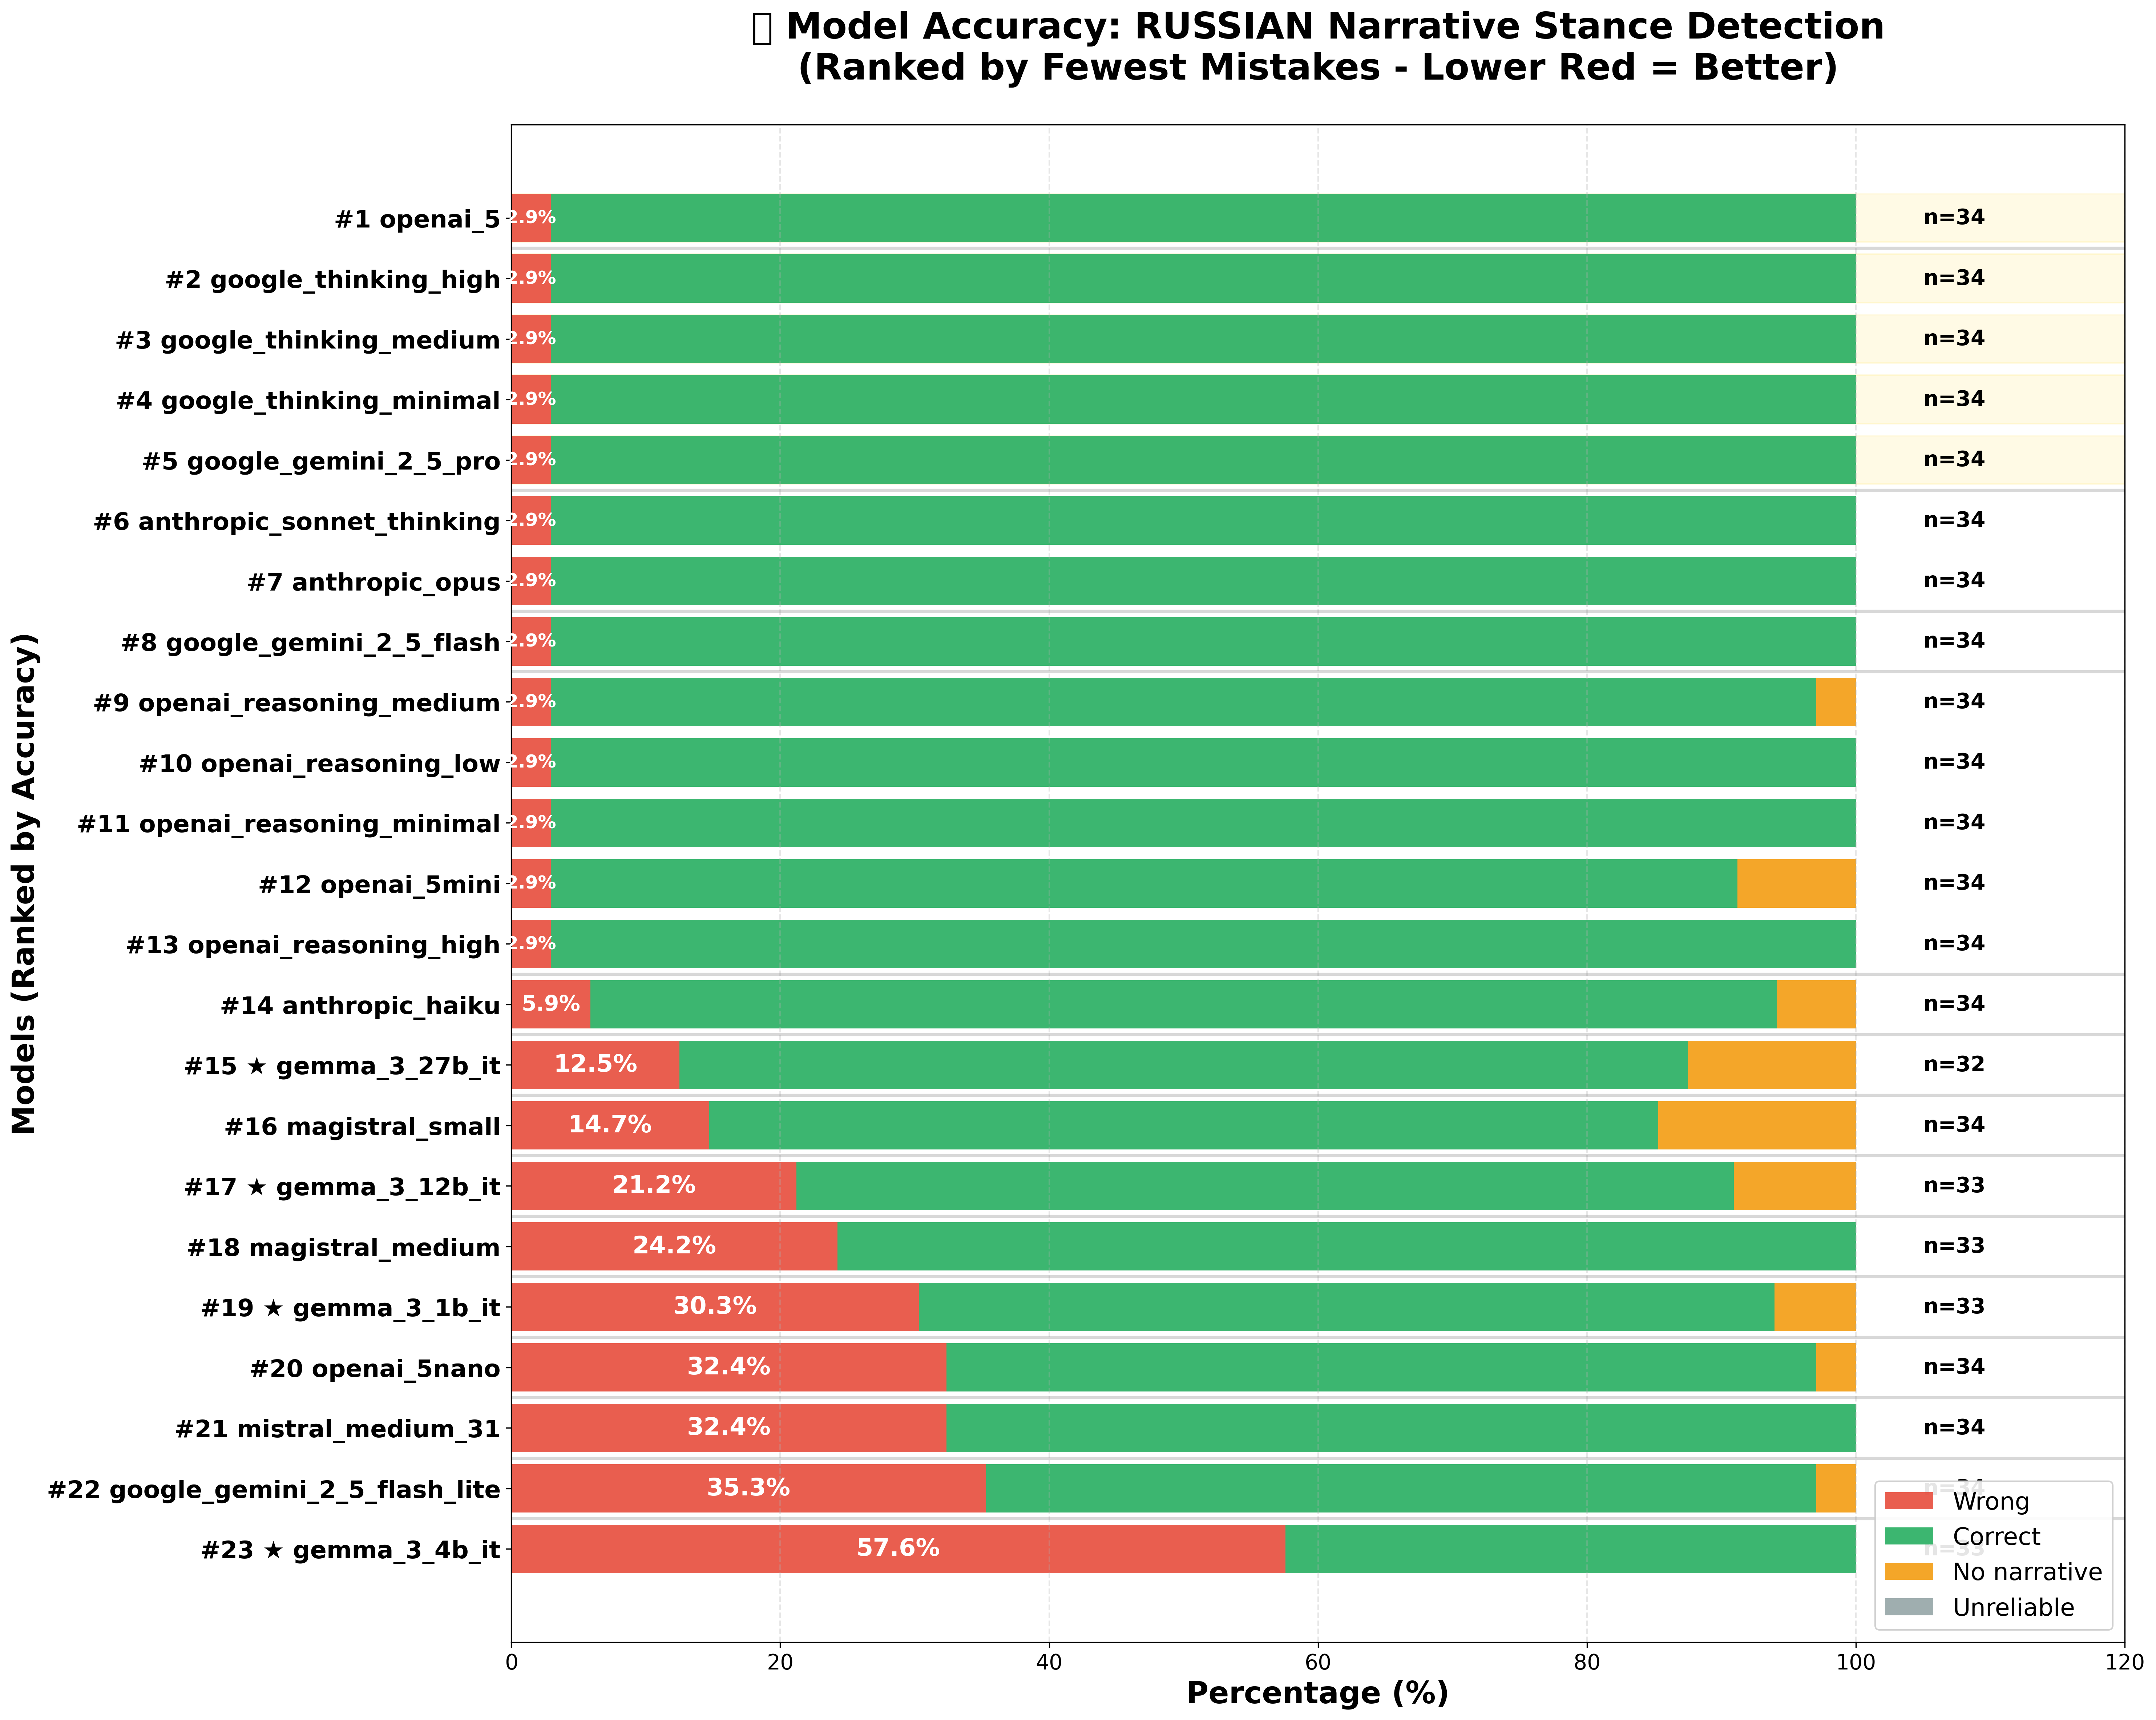


🎨 HIGH-RESOLUTION STANCE ACCURACY CHART COMPLETED!
📊 Features:
   ✅ ALL 23 models included
   📏 Figure size: 20 x 16 inches
   🔍 High resolution: 600 DPI
   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)
   ⭐ Gemma models marked with stars
   🏆 Top 5 models highlighted with golden background
   ❌ Critical mistakes (SaS in podporuje) highlighted in RED

💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:
   📄 PNG (600 DPI): stance_accuracy_russian_models_horizontal_HR_20250906_190426.png
   📄 PDF (600 DPI): stance_accuracy_russian_models_horizontal_HR_20250906_190426.pdf
   📄 SVG (Vector): stance_accuracy_russian_models_horizontal_HR_20250906_190426.svg

📐 CHART SPECIFICATIONS:
   📊 Chart dimensions: 20" × 16"
   🔤 Model names: 16pt bold font
   📈 Percentages: 14-16pt bold font
   📊 Total models displayed: 23
   🎯 Ranking: #1 (most accurate) to #23 (least accurate)


,model,model_type,mistake_pct,correct_pct,no_narrative_pct,unreliable_pct,total_predictions,is_gemma
0,openai_5,OpenAI,2.941176,97.058824,0.000000,0.0,34,False
15,google_thinking_high,Google,2.941176,97.058824,0.000000,0.0,34,False
14,google_thinking_medium,Google,2.941176,97.058824,0.000000,0.0,34,False
13,google_thinking_minimal,Google,2.941176,97.058824,0.000000,0.0,34,False
10,google_gemini_2_5_pro,Google,2.941176,97.058824,0.000000,0.0,34,False
9,anthropic_sonnet_thinking,Anthropic,2.941176,97.058824,0.000000,0.0,34,False
7,anthropic_opus,Anthropic,2.941176,97.058824,0.000000,0.0,34,False
11,google_gemini_2_5_flash,Google,2.941176,97.058824,0.000000,0.0,34,False
5,openai_reasoning_medium,OpenAI,2.941176,94.117647,2.941176,0.0,34,False
4,openai_reasoning_low,OpenAI,2.941176,97.058824,0.000000,0.0,34,False


In [33]:
create_stance_accuracy_chart(df_stance, narrative='russian')    

C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:230: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:236: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.png',
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:241: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.svg',
c:\Users\alexe\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


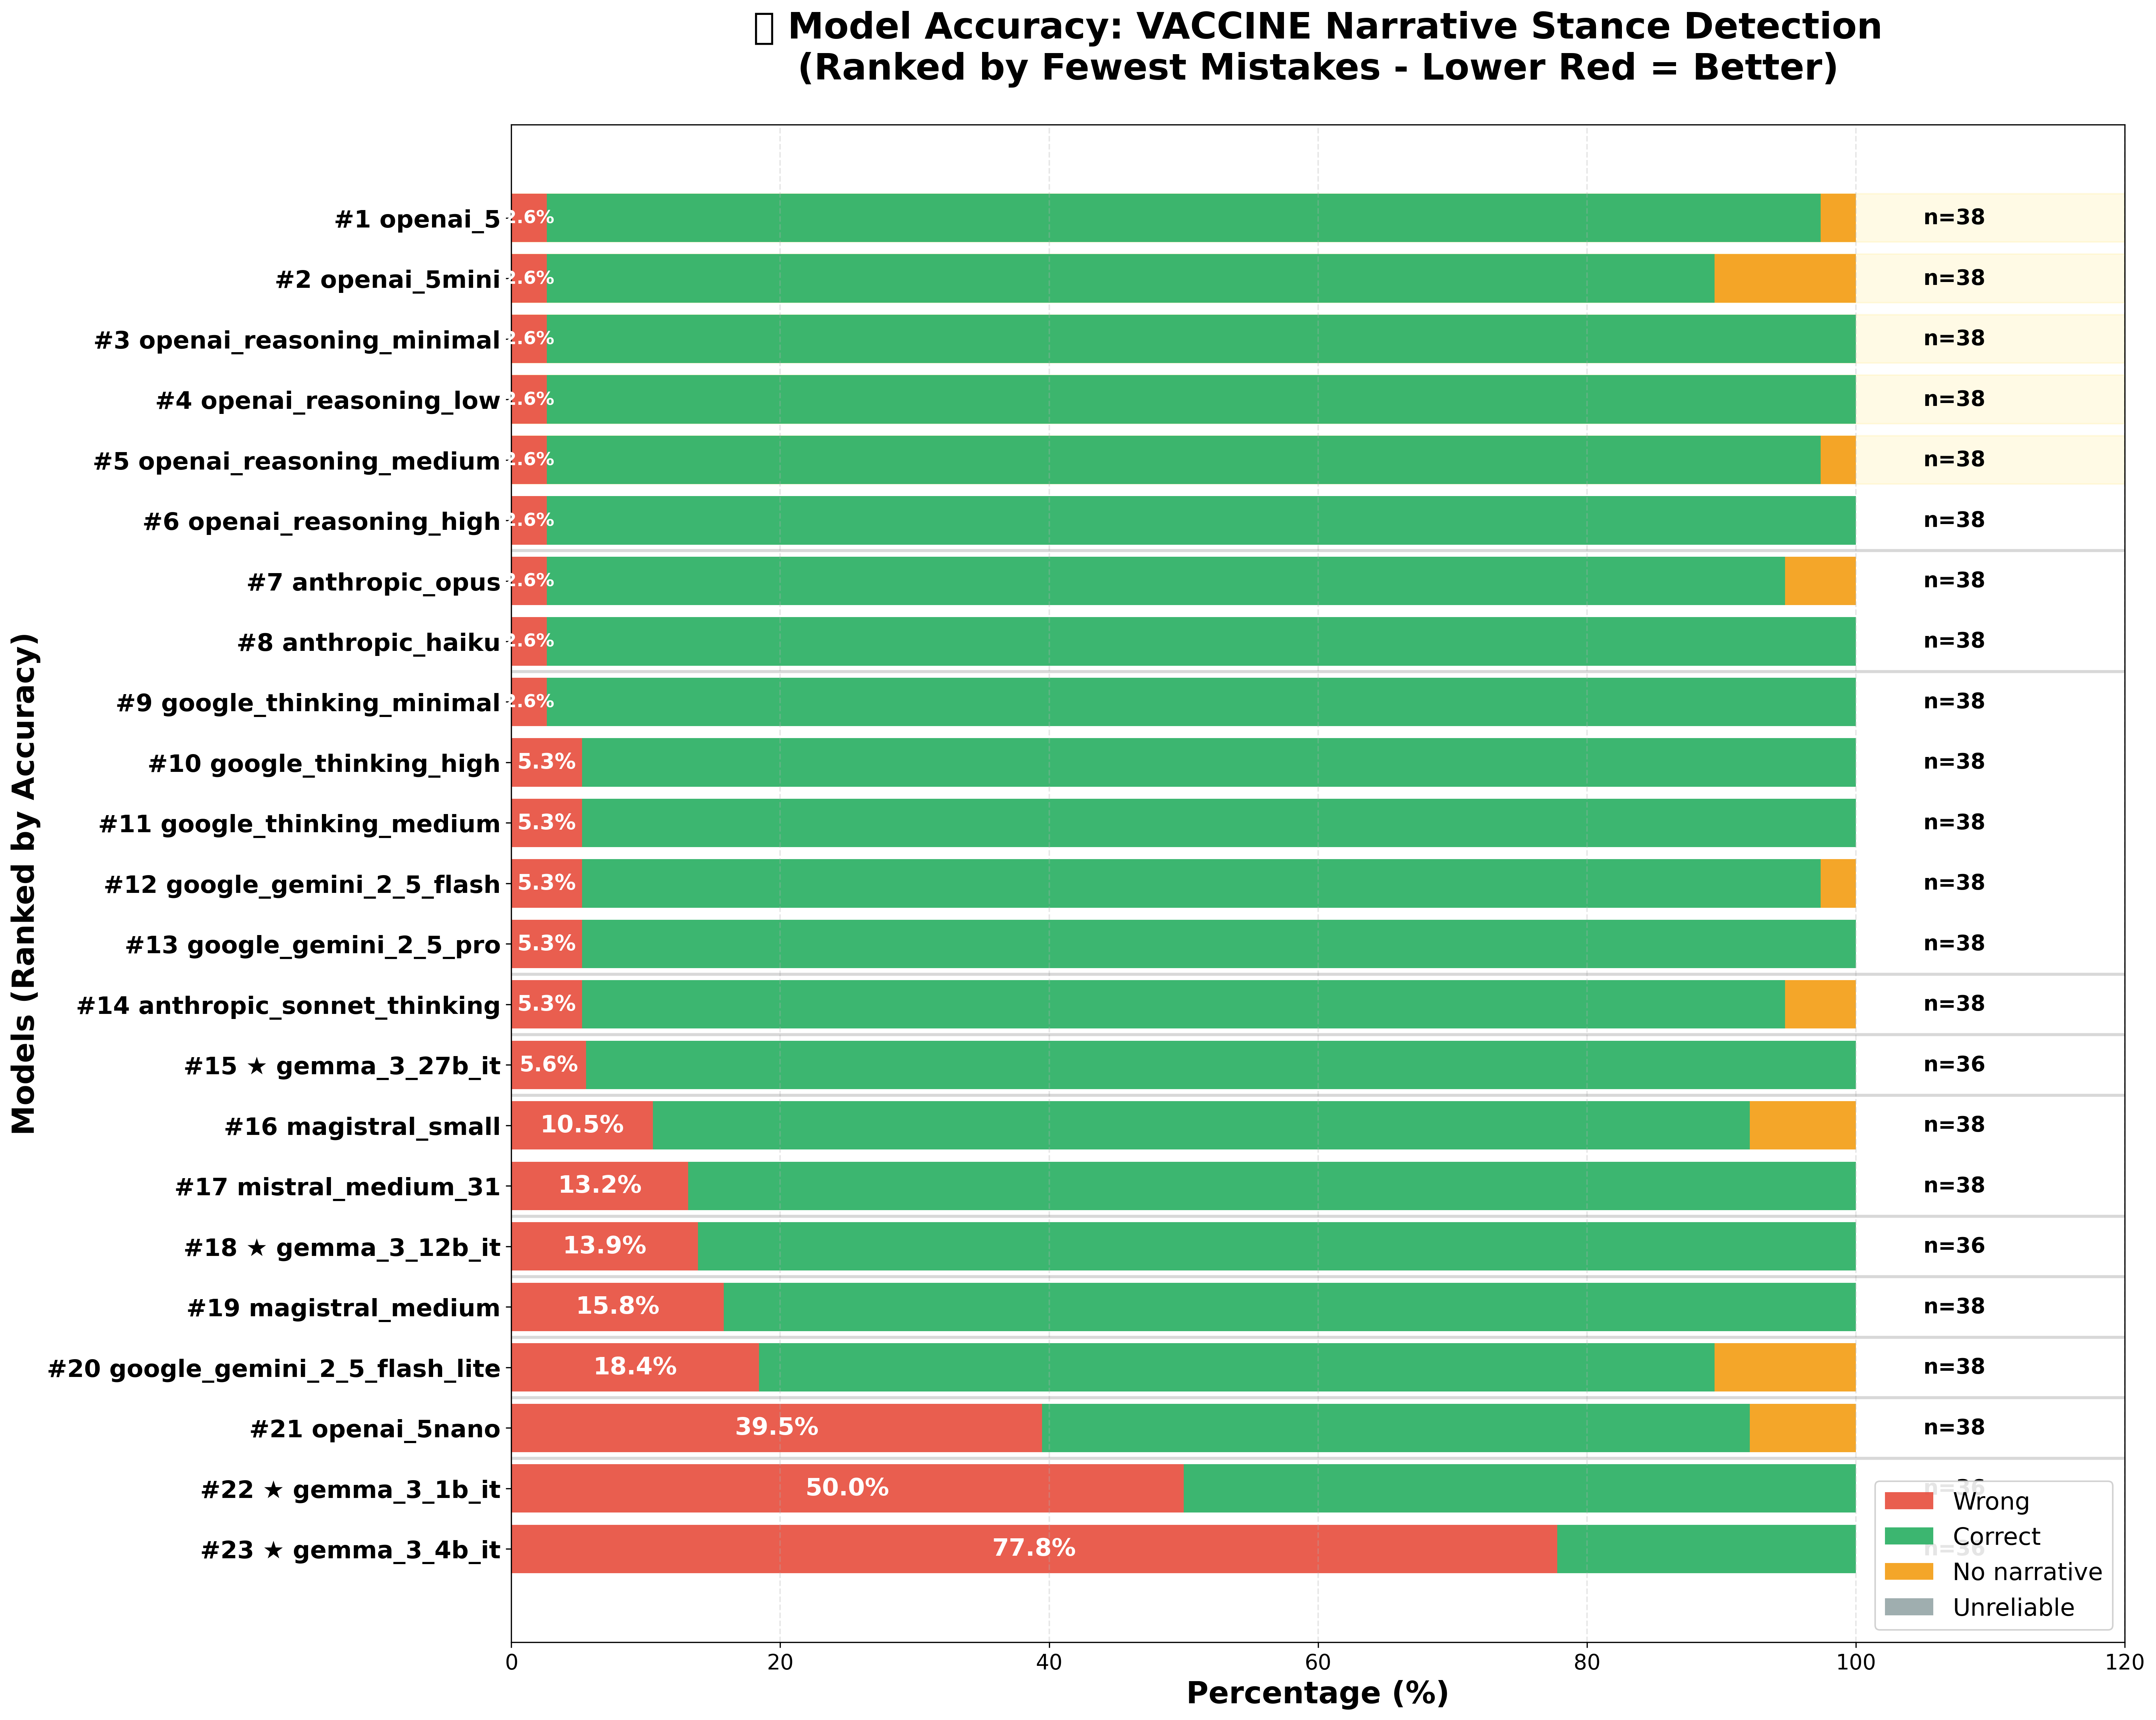


🎨 HIGH-RESOLUTION STANCE ACCURACY CHART COMPLETED!
📊 Features:
   ✅ ALL 23 models included
   📏 Figure size: 20 x 16 inches
   🔍 High resolution: 600 DPI
   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)
   ⭐ Gemma models marked with stars
   🏆 Top 5 models highlighted with golden background
   ❌ Critical mistakes (SaS in podporuje) highlighted in RED

💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:
   📄 PNG (600 DPI): stance_accuracy_vaccine_models_horizontal_HR_20250906_190432.png
   📄 PDF (600 DPI): stance_accuracy_vaccine_models_horizontal_HR_20250906_190432.pdf
   📄 SVG (Vector): stance_accuracy_vaccine_models_horizontal_HR_20250906_190432.svg

📐 CHART SPECIFICATIONS:
   📊 Chart dimensions: 20" × 16"
   🔤 Model names: 16pt bold font
   📈 Percentages: 14-16pt bold font
   📊 Total models displayed: 23
   🎯 Ranking: #1 (most accurate) to #23 (least accurate)


,model,model_type,mistake_pct,correct_pct,no_narrative_pct,unreliable_pct,total_predictions,is_gemma
0,openai_5,OpenAI,2.631579,94.736842,2.631579,0.0,38,False
1,openai_5mini,OpenAI,2.631579,86.842105,10.526316,0.0,38,False
3,openai_reasoning_minimal,OpenAI,2.631579,97.368421,0.000000,0.0,38,False
4,openai_reasoning_low,OpenAI,2.631579,97.368421,0.000000,0.0,38,False
5,openai_reasoning_medium,OpenAI,2.631579,94.736842,2.631579,0.0,38,False
6,openai_reasoning_high,OpenAI,2.631579,97.368421,0.000000,0.0,38,False
7,anthropic_opus,Anthropic,2.631579,92.105263,5.263158,0.0,38,False
8,anthropic_haiku,Anthropic,2.631579,97.368421,0.000000,0.0,38,False
13,google_thinking_minimal,Google,2.631579,97.368421,0.000000,0.0,38,False
15,google_thinking_high,Google,5.263158,94.736842,0.000000,0.0,38,False


In [34]:
create_stance_accuracy_chart(df_stance, narrative='vaccine')

C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:230: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:236: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.png',
C:\Users\alexe\AppData\Local\Temp\ipykernel_23024\1938422030.py:241: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(f'../graphs/stance_accuracy_llm{narrative}_models_horizontal_HR_{hr_timestamp}.svg',
c:\Users\alexe\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


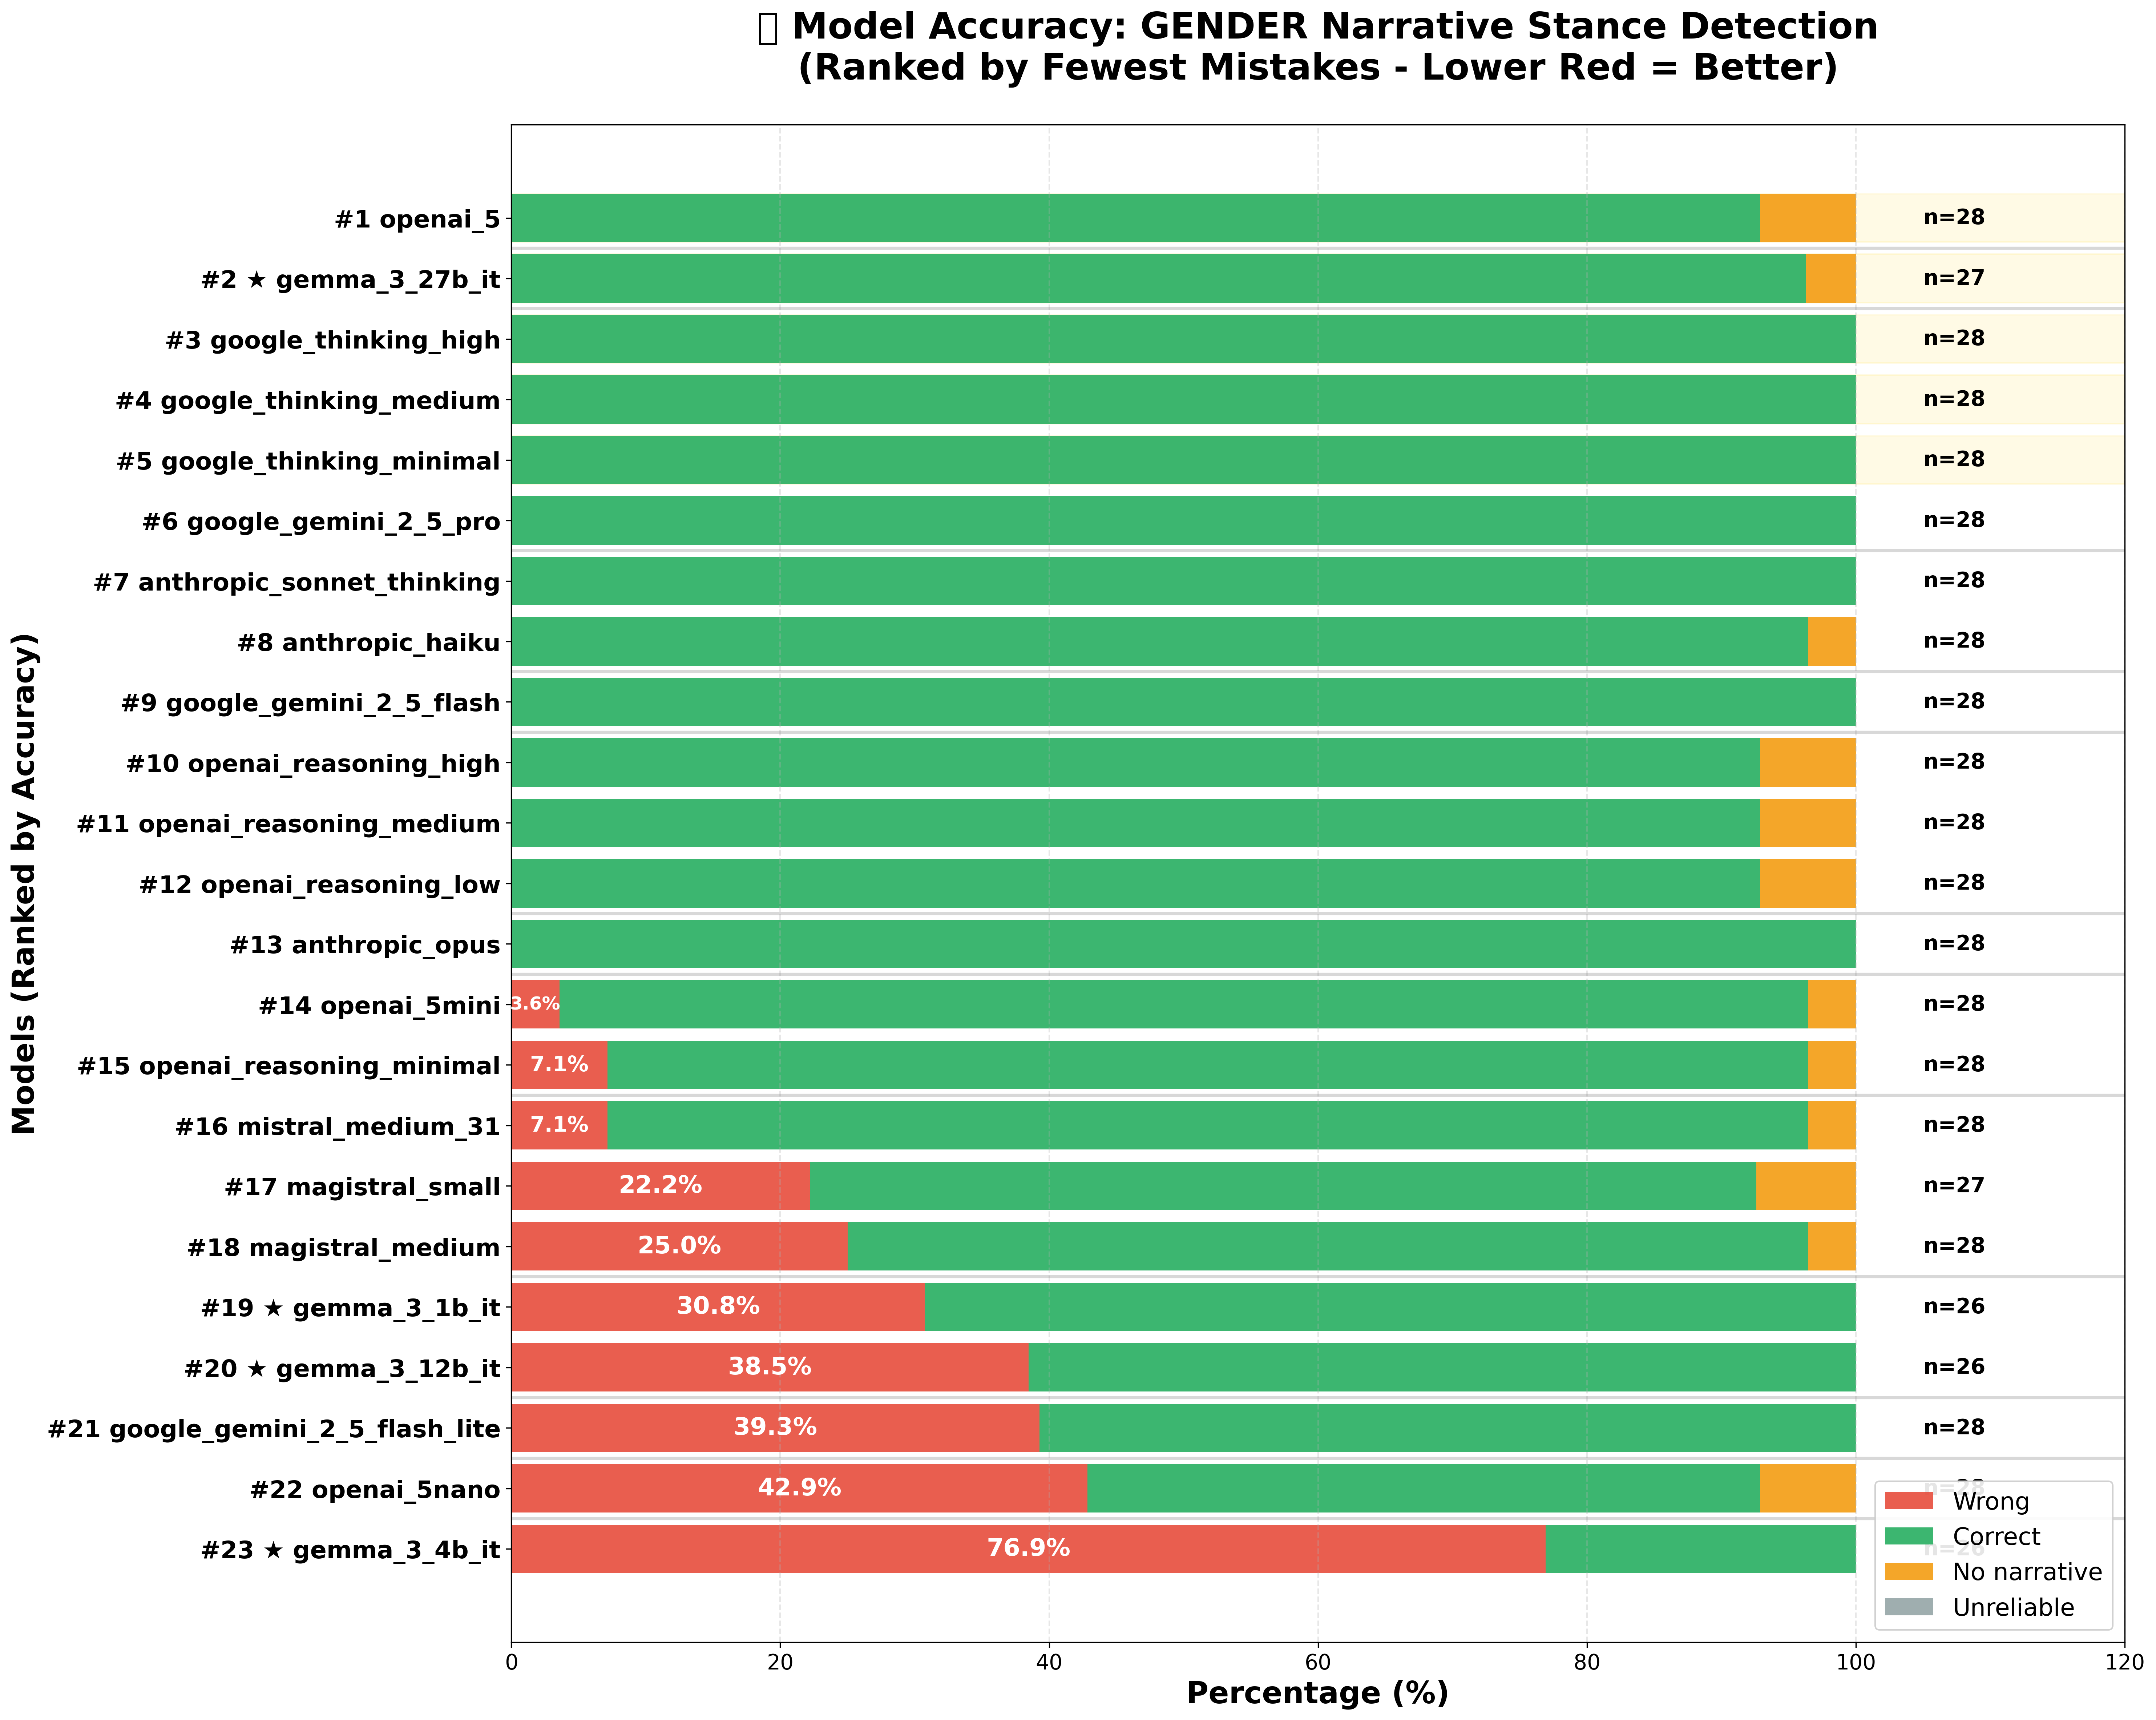


🎨 HIGH-RESOLUTION STANCE ACCURACY CHART COMPLETED!
📊 Features:
   ✅ ALL 23 models included
   📏 Figure size: 20 x 16 inches
   🔍 High resolution: 600 DPI
   📝 Enhanced font sizes (16pt model names, 16pt+ percentages)
   ⭐ Gemma models marked with stars
   🏆 Top 5 models highlighted with golden background
   ❌ Critical mistakes (SaS in podporuje) highlighted in RED

💾 SAVED IN MULTIPLE HIGH-RESOLUTION FORMATS:
   📄 PNG (600 DPI): stance_accuracy_gender_models_horizontal_HR_20250906_190438.png
   📄 PDF (600 DPI): stance_accuracy_gender_models_horizontal_HR_20250906_190438.pdf
   📄 SVG (Vector): stance_accuracy_gender_models_horizontal_HR_20250906_190438.svg

📐 CHART SPECIFICATIONS:
   📊 Chart dimensions: 20" × 16"
   🔤 Model names: 16pt bold font
   📈 Percentages: 14-16pt bold font
   📊 Total models displayed: 23
   🎯 Ranking: #1 (most accurate) to #23 (least accurate)


,model,model_type,mistake_pct,correct_pct,no_narrative_pct,unreliable_pct,total_predictions,is_gemma
0,openai_5,OpenAI,0.000000,92.857143,7.142857,0.0,28,False
19,gemma_3_27b_it,Gemma,0.000000,96.296296,3.703704,0.0,27,True
15,google_thinking_high,Google,0.000000,100.000000,0.000000,0.0,28,False
14,google_thinking_medium,Google,0.000000,100.000000,0.000000,0.0,28,False
13,google_thinking_minimal,Google,0.000000,100.000000,0.000000,0.0,28,False
10,google_gemini_2_5_pro,Google,0.000000,100.000000,0.000000,0.0,28,False
9,anthropic_sonnet_thinking,Anthropic,0.000000,100.000000,0.000000,0.0,28,False
8,anthropic_haiku,Anthropic,0.000000,96.428571,3.571429,0.0,28,False
11,google_gemini_2_5_flash,Google,0.000000,100.000000,0.000000,0.0,28,False
6,openai_reasoning_high,OpenAI,0.000000,92.857143,7.142857,0.0,28,False


In [35]:
create_stance_accuracy_chart(df_stance, narrative='gender')